In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    balanced_accuracy_score,
    roc_curve,
    confusion_matrix,
    auc,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
)
from sklearn.decomposition import PCA
from imblearn.over_sampling import (
    SMOTE,
    BorderlineSMOTE,
    SVMSMOTE,
    KMeansSMOTE,
)
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.neural_network import MLPClassifier
import optuna
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
df = pd.read_csv("PastLoans.csv")


def replace_digital3(row):
    if row["digital3"] == 0:
        if row["digital1"] != 0 and row["digital2"] != 0:
            return (row["digital1"] + row["digital2"]) / 2
        elif row["digital1"] != 0:
            return row["digital1"]
        elif row["digital2"] != 0:
            return row["digital2"]
    return row["digital3"]


df["digital3"] = df.apply(replace_digital3, axis=1)
df.drop(["digital1", "digital2"], axis=1, inplace=True)
df["log_income"] = np.log1p(df["income"])
df["income"] = StandardScaler().fit_transform(df["income"].values.reshape(-1, 1))
df = pd.get_dummies(df, columns=["employment", "sex"], drop_first=True)

In [3]:
X = df.drop("default", axis=1)

y = df["default"]

In [4]:
# Initialize PCA with the number of components you want
pca = PCA(n_components=2)

# Fit and transform the data
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA features
X_pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])

# Concatenate the PCA features with the original data
X = pd.concat([X, X_pca_df], axis=1)

X.head()


,married,income,digital3,log_income,employment_retired,employment_student,employment_unemployed,sex_M,PCA1,PCA2
0,0,-0.387029,0.738735,0.000000,False,False,True,True,-7.883155,0.335787
1,1,0.154879,0.733947,10.170035,False,False,False,True,2.331331,-0.048537
2,1,-0.141896,0.652496,9.376787,False,False,False,True,1.517539,-0.275625
3,1,-0.387029,0.000000,0.000000,False,False,True,True,-7.841934,0.300103
4,1,-0.256056,0.203202,8.750049,True,False,False,False,0.891399,-0.390752


In [78]:
# Export PCA model
import joblib

joblib.dump(pca, "pca_model.pkl")

['pca_model.pkl']

In [5]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


https://medium.com/totalenergies-digital-factory/imbalanced-data-ml-smote-and-its-variants-c69a4b32f7e7

In [6]:
# SMOTE
smote = SMOTE(random_state=42)

X_train_pca_smote, y_train_pca_smote = smote.fit_resample(X_train_pca, y_train_pca)


In [7]:
# MLP Classifier with PCA

mlp_model_pca = MLPClassifier(random_state=42)

mlp_model_pca.fit(X_train_pca_smote, y_train_pca_smote)

y_pred_pca = mlp_model_pca.predict(X_test_pca)

print("MLP Classifier with PCA")
print("Accuracy: ", accuracy_score(y_test_pca, y_pred_pca))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test_pca, y_pred_pca))
print(classification_report(y_test_pca, y_pred_pca))
print("ROC AUC: ", roc_auc_score(y_test_pca, y_pred_pca))


MLP Classifier with PCA
Accuracy:  0.60075
Balanced Accuracy:  0.6783709687049803
              precision    recall  f1-score   support

           0       0.96      0.58      0.72     18011
           1       0.17      0.78      0.28      1989

    accuracy                           0.60     20000
   macro avg       0.56      0.68      0.50     20000
weighted avg       0.88      0.60      0.68     20000

ROC AUC:  0.6783709687049803


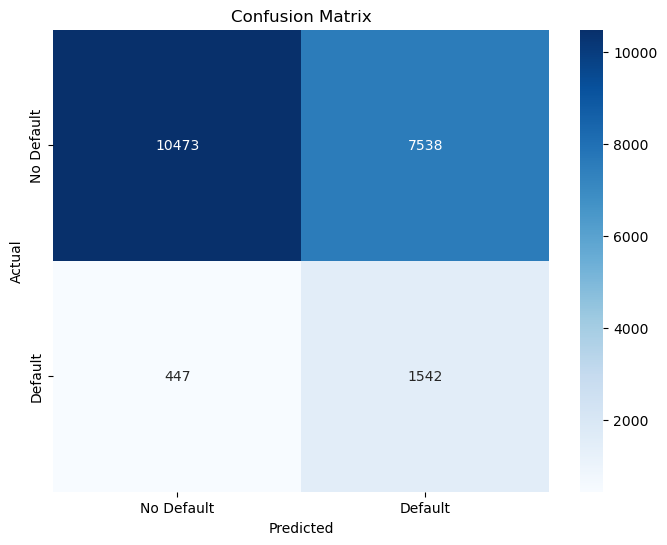

In [8]:
# Plot confusion matrix
cm = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Default", "Default"],
    yticklabels=["No Default", "Default"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


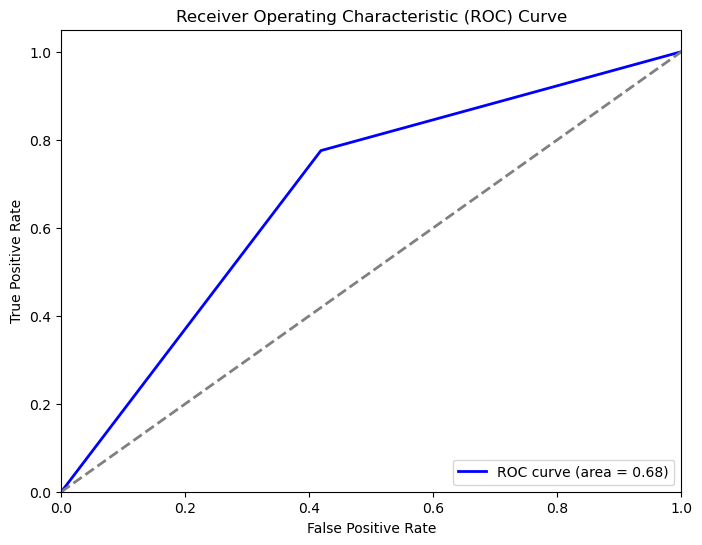

In [9]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_pca, y_pred_pca)
roc_auc_mlp_pca = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc_mlp_pca:.2f})"
)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Best Threshold for F1 score:  0.6464646464646465


c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fair

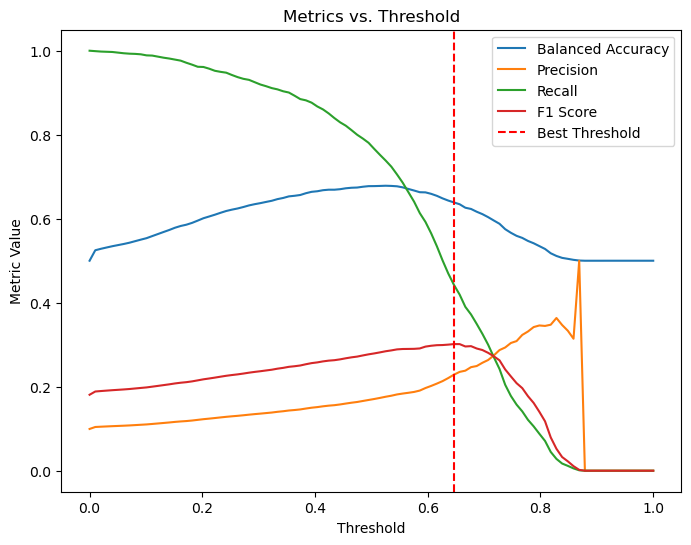

In [10]:
y_prob_pca = mlp_model_pca.predict_proba(X_test_pca)[:, 1]

# Define a range of thresholds to test
thresholds = np.linspace(0, 1, 100)

# Initialize lists to store the metrics
balanced_accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Iterate over the thresholds and compute the metrics
for threshold in thresholds:
    y_pred_threshold = y_prob_pca > threshold
    balanced_accuracy = balanced_accuracy_score(y_test_pca, y_pred_threshold)
    precision = precision_score(y_test_pca, y_pred_threshold)
    recall = recall_score(y_test_pca, y_pred_threshold)
    f1 = f1_score(y_test_pca, y_pred_threshold)
    balanced_accuracy_list.append(balanced_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Find the best threshold
best_threshold = thresholds[np.argmax(f1_list)]

print("Best Threshold for F1 score: ", best_threshold)

# Plot the metrics as a function of the threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, balanced_accuracy_list, label="Balanced Accuracy")
plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")
plt.plot(thresholds, f1_list, label="F1 Score")
plt.axvline(best_threshold, color="red", linestyle="--", label="Best Threshold")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs. Threshold")
plt.legend(loc="best")
plt.show()


MLP Classifier with PCA and Best Threshold
Accuracy:  0.79615
Balanced Accuracy:  0.6388225993058987
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     18011
           1       0.23      0.44      0.30      1989

    accuracy                           0.80     20000
   macro avg       0.58      0.64      0.59     20000
weighted avg       0.86      0.80      0.82     20000

ROC AUC:  0.6388225993058987


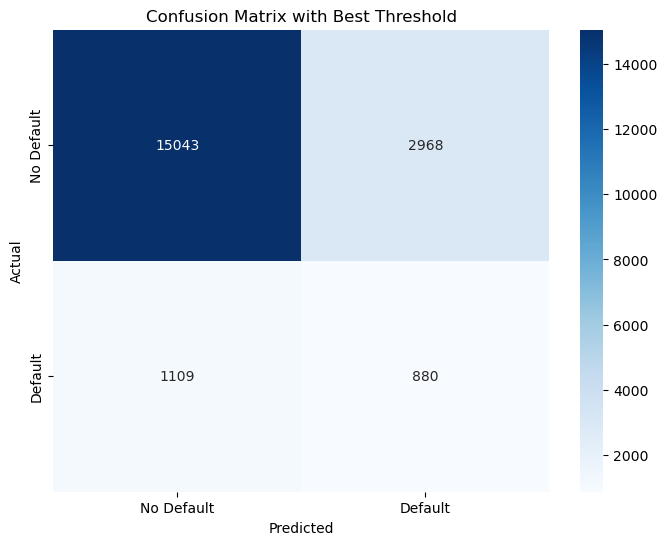

In [11]:
# Predict with the best threshold
y_pred_best_threshold = y_prob_pca > best_threshold

print("MLP Classifier with PCA and Best Threshold")
print("Accuracy: ", accuracy_score(y_test_pca, y_pred_best_threshold))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test_pca, y_pred_best_threshold))
print(classification_report(y_test_pca, y_pred_best_threshold))
print("ROC AUC: ", roc_auc_score(y_test_pca, y_pred_best_threshold))

# Confusion Matrix with the best threshold
cm = confusion_matrix(y_test_pca, y_pred_best_threshold)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Default", "Default"],
    yticklabels=["No Default", "Default"],
)
plt.title("Confusion Matrix with Best Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [12]:
# Split without sampling for hyperparameter tuning

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
def objective(trial):
    try:
        # SMOTE strategy choice
        smote_strategies = {
            "SMOTE": SMOTE(),
            "SMOTETomek": SMOTETomek(),
            "SMOTEENN": SMOTEENN(),
            "BorderlineSMOTE": BorderlineSMOTE(),
            "SVMSMOTE": SVMSMOTE(),
            # Temporarily exclude KMeansSMOTE to avoid the error
            # 'KMeansSMOTE': KMeansSMOTE(n_clusters=trial.suggest_int('n_clusters', 2, 10),
            #                            cluster_balance_threshold=trial.suggest_float('cluster_balance_threshold', 0.01, 0.5))
        }
        smote_strategy = trial.suggest_categorical(
            "smote_strategy", list(smote_strategies.keys())
        )

        # MLP hyperparameters
        hidden_layer_sizes = trial.suggest_int("hidden_layer_sizes", 50, 200)
        activation = trial.suggest_categorical(
            "activation", ["identity", "logistic", "tanh", "relu"]
        )
        solver = trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"])
        alpha = trial.suggest_float("alpha", 1e-5, 1e-3, log=True)
        learning_rate = trial.suggest_categorical(
            "learning_rate", ["constant", "invscaling", "adaptive"]
        )

        # Create the pipeline
        pipeline = ImbPipeline(
            [
                ("scaler", StandardScaler()),
                ("smote", smote_strategies[smote_strategy]),
                (
                    "mlp",
                    MLPClassifier(
                        hidden_layer_sizes=(hidden_layer_sizes,),
                        activation=activation,
                        solver=solver,
                        alpha=alpha,
                        learning_rate=learning_rate,
                        max_iter=1000,
                        random_state=42,
                        early_stopping=True,
                    ),
                ),
            ]
        )

        # Cross-validation
        cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)

        # Scoring metric
        scoring = make_scorer(roc_auc_score, average="weighted")

        # Cross-validation evaluation
        scores = cross_val_score(
            pipeline, X_train_pca, y_train_pca, cv=cv, scoring=scoring
        )

        return np.mean(scores)

    except Exception as e:
        # Gracefully handle any error by skipping the trial
        print(f"Trial failed with error: {str(e)}")
        return None


In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-10-19 18:19:41,696] A new study created in memory with name: no-name-3677a331-b5bf-49ac-9f3f-571e9ecbb85d
[I 2024-10-19 18:20:31,872] Trial 0 finished with value: 0.6747988497604399 and parameters: {'smote_strategy': 'SMOTETomek', 'hidden_layer_sizes': 58, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 5.6184237067925006e-05, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.6747988497604399.
[I 2024-10-19 18:21:00,012] Trial 1 finished with value: 0.6760366398446847 and parameters: {'smote_strategy': 'BorderlineSMOTE', 'hidden_layer_sizes': 141, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0003436174050438533, 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.6760366398446847.
[I 2024-10-19 18:21:20,312] Trial 2 finished with value: 0.6767785299745971 and parameters: {'smote_strategy': 'SMOTE', 'hidden_layer_sizes': 173, 'activation': 'relu', 'solver': 'adam', 'alpha': 2.3455888044411988e-05, 'learning_rate': 'adaptive'}. Best is trial 2 with value: 

In [19]:
best_params = study.best_params

In [20]:
best_params

{'smote_strategy': 'SMOTE',
 'hidden_layer_sizes': 173,
 'activation': 'relu',
 'solver': 'adam',
 'alpha': 2.3455888044411988e-05,
 'learning_rate': 'adaptive'}

In [24]:
# {
#     "smote_strategy": "SMOTE",
#     "hidden_layer_sizes": 173,
#     "activation": "relu",
#     "solver": "adam",
#     "alpha": 2.3455888044411988e-05,
#     "learning_rate": "adaptive",
# }


In [51]:
# Train the model with the best hyperparameters

# Create the pipeline
pipeline = ImbPipeline(
    [
        ("scaler", StandardScaler()),
        ("smote", SMOTE()),
        (
            "mlp",
            MLPClassifier(
                hidden_layer_sizes=(best_params["hidden_layer_sizes"],),
                activation=best_params["activation"],
                solver=best_params["solver"],
                alpha=best_params["alpha"],
                learning_rate=best_params["learning_rate"],
                max_iter=1000,
                random_state=42,
                early_stopping=True,
            ),
        ),
    ]
)

In [52]:
pipeline.fit(X_train_pca, y_train_pca)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE()),
                ('mlp',
                 MLPClassifier(alpha=2.3455888044411988e-05,
                               early_stopping=True, hidden_layer_sizes=(173,),
                               learning_rate='adaptive', max_iter=1000,
                               random_state=42))])

In [53]:
y_pred_pca = pipeline.predict(X_test_pca)

print("MLP Classifier with PCA and Hyperparameter Tuning")
print("Accuracy: ", accuracy_score(y_test_pca, y_pred_pca))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test_pca, y_pred_pca))
print(classification_report(y_test_pca, y_pred_pca))
print("ROC AUC: ", roc_auc_score(y_test_pca, y_pred_pca))

MLP Classifier with PCA and Hyperparameter Tuning
Accuracy:  0.6212
Balanced Accuracy:  0.6780968079978162
              precision    recall  f1-score   support

           0       0.96      0.61      0.74     18011
           1       0.17      0.75      0.28      1989

    accuracy                           0.62     20000
   macro avg       0.57      0.68      0.51     20000
weighted avg       0.88      0.62      0.70     20000

ROC AUC:  0.6780968079978162


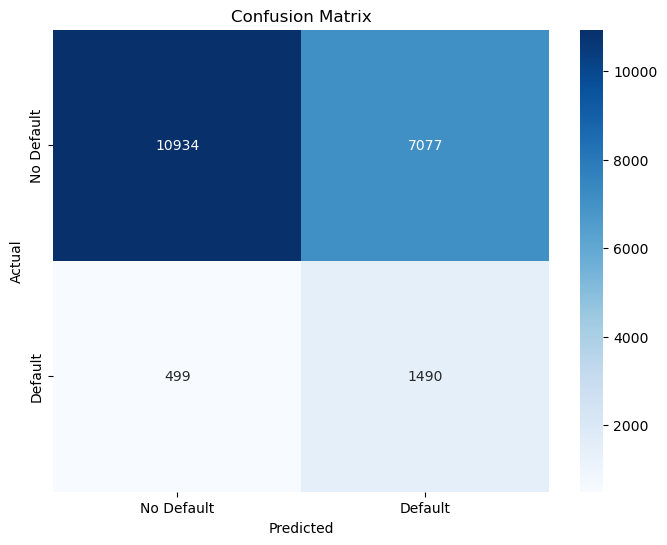

In [54]:
# Plot confusion matrix
cm = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Default", "Default"],
    yticklabels=["No Default", "Default"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


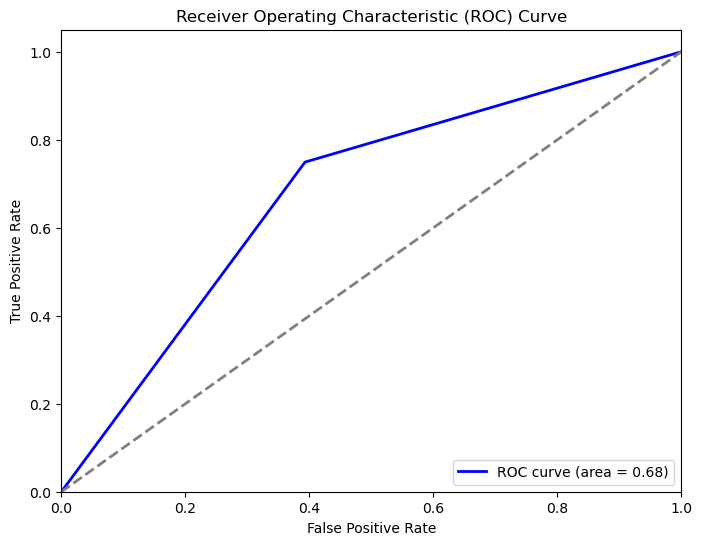

In [55]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_pca, y_pred_pca)
roc_auc_mlp_pca = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc_mlp_pca:.2f})"
)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fair

Best Threshold for balanced accuracy:  0.48484848484848486


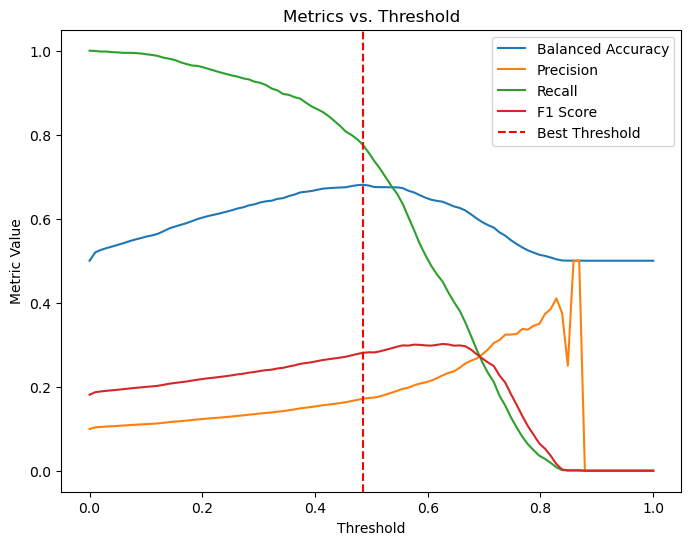

In [62]:
y_prob_pca = pipeline.predict_proba(X_test_pca)[:, 1]

# Define a range of thresholds to test
thresholds = np.linspace(0, 1, 100)

# Initialize lists to store the metrics
balanced_accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Iterate over the thresholds and compute the metrics
for threshold in thresholds:
    y_pred_threshold = y_prob_pca > threshold
    balanced_accuracy = balanced_accuracy_score(y_test_pca, y_pred_threshold)
    precision = precision_score(y_test_pca, y_pred_threshold)
    recall = recall_score(y_test_pca, y_pred_threshold)
    f1 = f1_score(y_test_pca, y_pred_threshold)
    balanced_accuracy_list.append(balanced_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Find the best threshold
# best_threshold = thresholds[np.argmax(f1_list)]
best_threshold = thresholds[np.argmax(balanced_accuracy_list)]

print("Best Threshold for balanced accuracy: ", best_threshold)

# Plot the metrics as a function of the threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, balanced_accuracy_list, label="Balanced Accuracy")
plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")
plt.plot(thresholds, f1_list, label="F1 Score")
plt.axvline(best_threshold, color="red", linestyle="--", label="Best Threshold")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs. Threshold")
plt.legend(loc="best")
plt.show()


MLP Classifier with PCA and Best Threshold
Accuracy:  0.60445
Balanced Accuracy:  0.680872512437863
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     18011
           1       0.17      0.78      0.28      1989

    accuracy                           0.60     20000
   macro avg       0.57      0.68      0.50     20000
weighted avg       0.88      0.60      0.68     20000

ROC AUC:  0.680872512437863


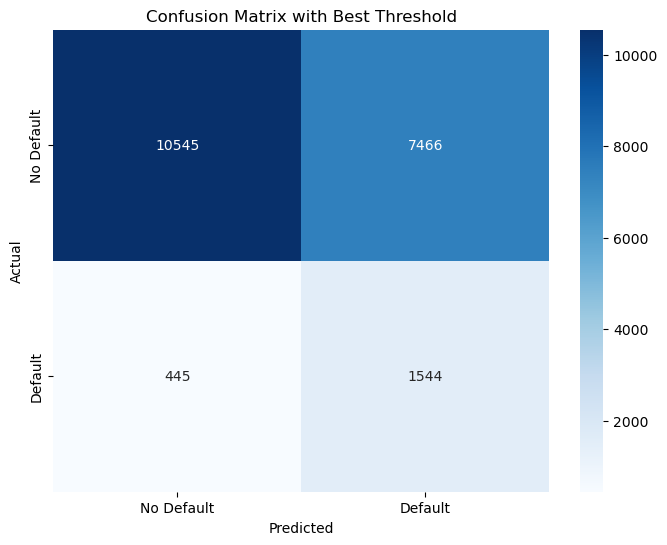

In [63]:
# Predict with the best threshold
y_pred_best_threshold = y_prob_pca > best_threshold

print("MLP Classifier with PCA and Best Threshold")
print("Accuracy: ", accuracy_score(y_test_pca, y_pred_best_threshold))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test_pca, y_pred_best_threshold))
print(classification_report(y_test_pca, y_pred_best_threshold))
print("ROC AUC: ", roc_auc_score(y_test_pca, y_pred_best_threshold))

# Confusion Matrix with the best threshold
cm = confusion_matrix(y_test_pca, y_pred_best_threshold)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Default", "Default"],
    yticklabels=["No Default", "Default"],
)
plt.title("Confusion Matrix with Best Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


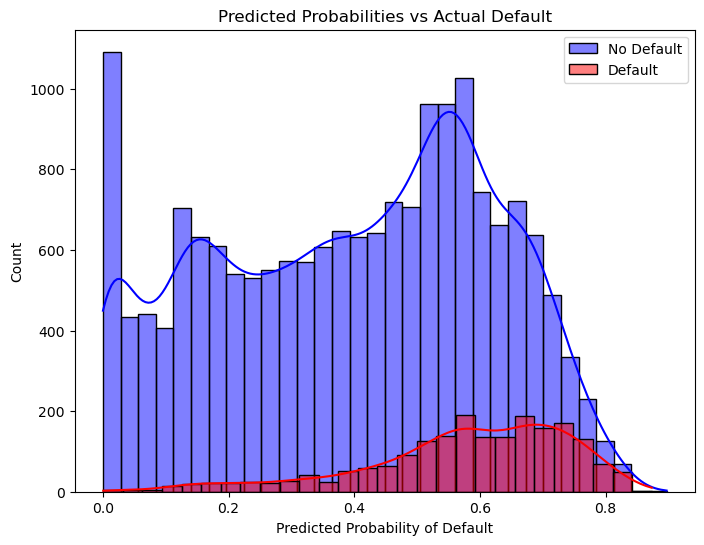

In [64]:
# Plot probabilities vs actual default

plt.figure(figsize=(8, 6))
sns.histplot(y_prob_pca[y_test_pca == 0], color="blue", kde=True, label="No Default")
sns.histplot(y_prob_pca[y_test_pca == 1], color="red", kde=True, label="Default")
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Count")
plt.title("Predicted Probabilities vs Actual Default")
plt.legend(loc="best")
plt.show()


In [65]:
# Check model performance on entire dataset with best threshold

y_pred_best_threshold = pipeline.predict_proba(X)[:, 1] > best_threshold

print("MLP Classifier with PCA and Best Threshold on Entire Dataset")
print("Accuracy: ", accuracy_score(y, y_pred_best_threshold))
print("Balanced Accuracy: ", balanced_accuracy_score(y, y_pred_best_threshold))
print(classification_report(y, y_pred_best_threshold))
print("ROC AUC: ", roc_auc_score(y, y_pred_best_threshold))


MLP Classifier with PCA and Best Threshold on Entire Dataset
Accuracy:  0.60522
Balanced Accuracy:  0.6794846484241063
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     90053
           1       0.17      0.77      0.28      9947

    accuracy                           0.61    100000
   macro avg       0.56      0.68      0.50    100000
weighted avg       0.88      0.61      0.68    100000

ROC AUC:  0.6794846484241062


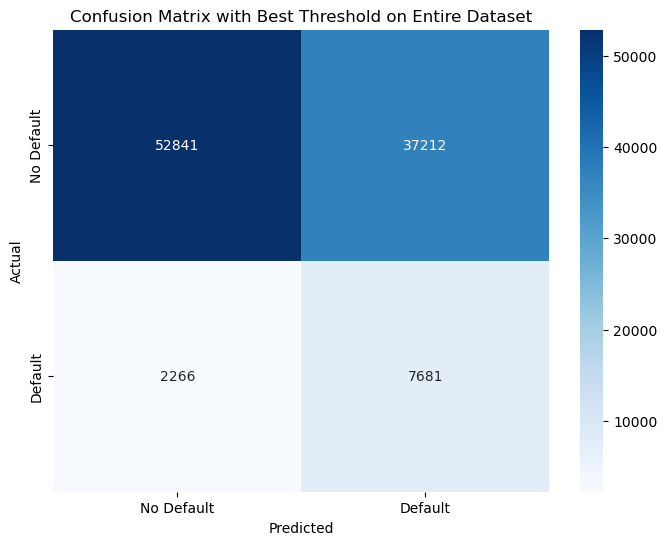

In [67]:
# Confusion Matrix with the best threshold
cm = confusion_matrix(y, y_pred_best_threshold)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Default", "Default"],
    yticklabels=["No Default", "Default"],
)
plt.title("Confusion Matrix with Best Threshold on Entire Dataset")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [66]:
from sklearn.metrics import brier_score_loss

brier_score = brier_score_loss(y, y_pred_best_threshold)
print("Brier Score: ", brier_score)


Brier Score:  0.39478


### Calibrated Model

In [69]:
# Probability Calibration
from sklearn.calibration import CalibratedClassifierCV

# Create the pipeline
pipeline = ImbPipeline(
    [
        ("scaler", StandardScaler()),
        ("smote", SMOTE()),
        (
            "mlp",
            MLPClassifier(
                hidden_layer_sizes=(best_params["hidden_layer_sizes"],),
                activation=best_params["activation"],
                solver=best_params["solver"],
                alpha=best_params["alpha"],
                learning_rate=best_params["learning_rate"],
                max_iter=1000,
                random_state=42,
                early_stopping=True,
            ),
        ),
    ]
)

# Calibrate the pipeline
calibrated_pipeline = CalibratedClassifierCV(pipeline, method="sigmoid", cv=5)

# Fit the calibrated pipeline
calibrated_pipeline.fit(X_train_pca, y_train_pca)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('smote', SMOTE()),
                                                 ('mlp',
                                                  MLPClassifier(alpha=2.3455888044411988e-05,
                                                                early_stopping=True,
                                                                hidden_layer_sizes=(173,),
                                                                learning_rate='adaptive',
                                                                max_iter=1000,
                                                                random_state=42))]))

c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fair

Best Threshold for F1 score:  0.17171717171717174


c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fairness\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ameya\.conda\envs\fair

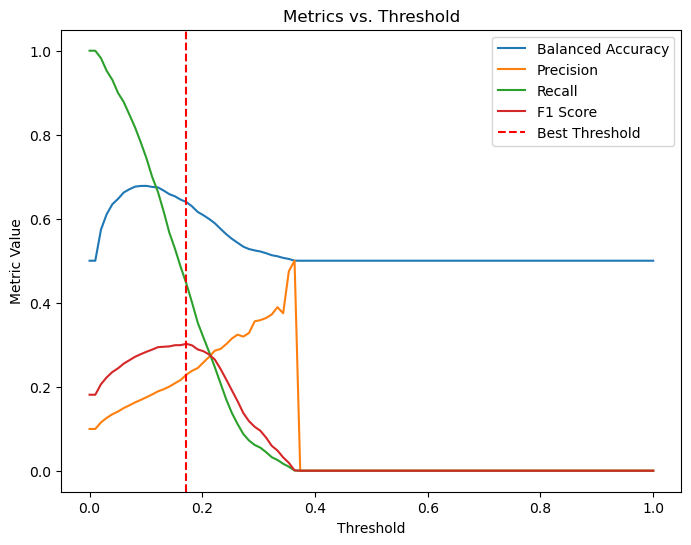

In [70]:
y_prob_pca = calibrated_pipeline.predict_proba(X_test_pca)[:, 1]

# Define a range of thresholds to test
thresholds = np.linspace(0, 1, 100)

# Initialize lists to store the metrics
balanced_accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Iterate over the thresholds and compute the metrics
for threshold in thresholds:
    y_pred_threshold = y_prob_pca > threshold
    balanced_accuracy = balanced_accuracy_score(y_test_pca, y_pred_threshold)
    precision = precision_score(y_test_pca, y_pred_threshold)
    recall = recall_score(y_test_pca, y_pred_threshold)
    f1 = f1_score(y_test_pca, y_pred_threshold)
    balanced_accuracy_list.append(balanced_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Find the best threshold
best_threshold = thresholds[np.argmax(f1_list)]

print("Best Threshold for F1 score: ", best_threshold)

# Plot the metrics as a function of the threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, balanced_accuracy_list, label="Balanced Accuracy")
plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")
plt.plot(thresholds, f1_list, label="F1 Score")
plt.axvline(best_threshold, color="red", linestyle="--", label="Best Threshold")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs. Threshold")
plt.legend(loc="best")
plt.show()


In [71]:
# Predict with the best threshold
y_pred_best_threshold = y_prob_pca > best_threshold

print("MLP Classifier with PCA, Hyperparameter Tuning, and Probability Calibration")
print("Accuracy: ", accuracy_score(y_test_pca, y_pred_best_threshold))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test_pca, y_pred_best_threshold))
print(classification_report(y_test_pca, y_pred_best_threshold))
print("ROC AUC: ", roc_auc_score(y_test_pca, y_pred_best_threshold))

MLP Classifier with PCA, Hyperparameter Tuning, and Probability Calibration
Accuracy:  0.79545
Balanced Accuracy:  0.6397756786751094
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     18011
           1       0.23      0.45      0.30      1989

    accuracy                           0.80     20000
   macro avg       0.58      0.64      0.59     20000
weighted avg       0.86      0.80      0.82     20000

ROC AUC:  0.6397756786751094


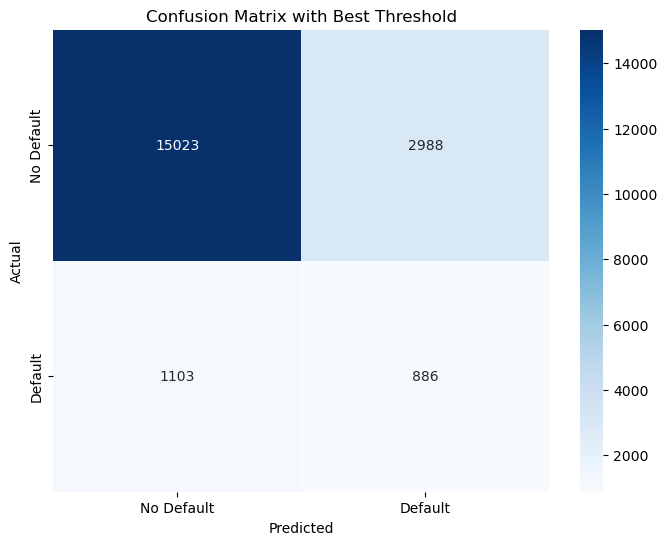

In [72]:
# Confusion Matrix with the best threshold
cm = confusion_matrix(y_test_pca, y_pred_best_threshold)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Default", "Default"],
    yticklabels=["No Default", "Default"],
)
plt.title("Confusion Matrix with Best Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

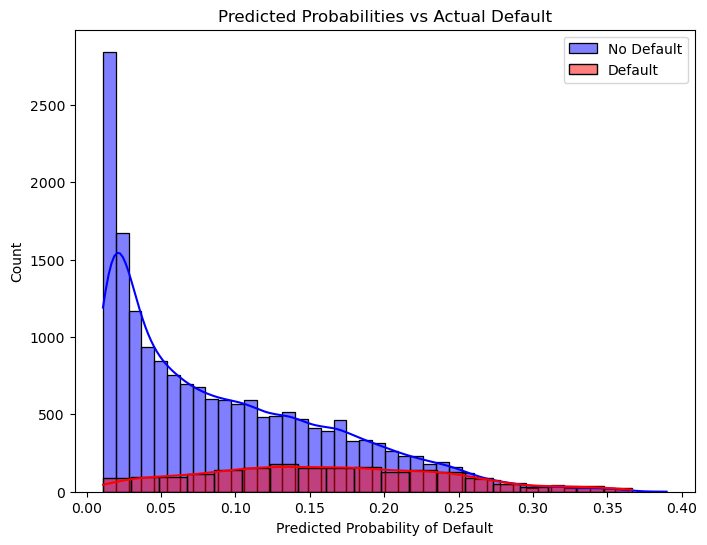

In [73]:
# Plot probabilities vs actual default

plt.figure(figsize=(8, 6))
sns.histplot(y_prob_pca[y_test_pca == 0], color="blue", kde=True, label="No Default")
sns.histplot(y_prob_pca[y_test_pca == 1], color="red", kde=True, label="Default")
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Count")
plt.title("Predicted Probabilities vs Actual Default")
plt.legend(loc="best")
plt.show()


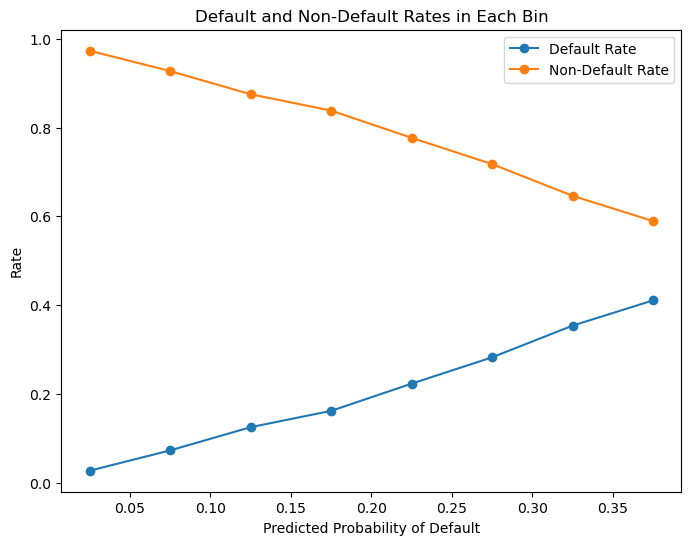

In [80]:
# Create bins with size 0.05
bins = np.arange(0, 1.05, 0.05)

# Bin probabilities and calculate the number of defaults and non-defaults in each bin
y_prob_binned = np.digitize(y_prob_pca, bins)
df_binned = pd.DataFrame({"y_prob": y_prob_binned, "y": y_test_pca})
df_binned["count"] = 1
df_binned = df_binned.groupby(["y_prob", "y"]).count().reset_index()
df_binned = df_binned.pivot(index="y_prob", columns="y", values="count").fillna(0)
df_binned["total"] = df_binned[0] + df_binned[1]
df_binned["default_rate"] = df_binned[1] / df_binned["total"]
df_binned["non_default_rate"] = df_binned[0] / df_binned["total"]

# Use the bin centers (midpoints) for plotting
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Midpoints of the bins

# Only plot data for the bins that exist in df_binned
valid_bins = df_binned.index - 1  # Adjust for zero-indexing from np.digitize

# Plot the default and non-default rates in each valid bin
plt.figure(figsize=(8, 6))
plt.plot(
    bin_centers[valid_bins], df_binned["default_rate"], label="Default Rate", marker="o"
)
plt.plot(
    bin_centers[valid_bins],
    df_binned["non_default_rate"],
    label="Non-Default Rate",
    marker="o",
)
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Rate")
plt.title("Default and Non-Default Rates in Each Bin")
plt.legend(loc="best")
plt.show()


As expected, the default rate (blue line) increases with the predicted probability of default, while the non-default rate (orange line) decreases.
This binning strategy demonstrates that the model is calibrated correctly: higher predicted probabilities correlate with higher actual default rates, and lower predicted probabilities correlate with higher non-default rates.

In [74]:
# Brier Score
brier_score = brier_score_loss(y_test_pca, y_prob_pca)
print("Brier Score: ", brier_score)

Brier Score:  0.08336733777245686


Key Observations:

1. Predicted Probability Distribution:
    After calibration, the predicted probabilities for both "Default" and "No Default" classes have shifted significantly.
    - For the No Default class (blue bars), the majority of predicted probabilities are now heavily concentrated near 0.0. This indicates the model has become more cautious and assigns very low probabilities of default to most instances.
    - For the Default class (red bars), the probabilities are more spread out but remain relatively low (mostly below 0.3). The model is assigning probabilities with much lower confidence overall than before.

2. Brier Score Improvement:
    The Brier score has dropped significantly, from 0.39478 (uncalibrated) to 0.0834 (calibrated). This indicates that the calibrated model's probability estimates are much more accurate on average, reflecting true probabilities more closely.
    - The lower Brier score indicates that calibration has made the model more reliable in terms of assigning probabilities, even though those probabilities are lower than before.

3. Shift in Probability Distribution:
    Calibration has shifted the predicted probabilities to be more reflective of the class imbalance. This is evident from the fact that most of the probabilities for "Default" are now small (since default is likely a rare event).
    - The extreme skew towards very low probabilities in the "No Default" class indicates that the model is highly confident about correctly predicting non-default cases. However, the calibrated model is now more conservative when predicting the default, meaning it's less likely to assign high probabilities of default.

Analysis:

1. Improved Probability Calibration: The substantial improvement in the Brier score suggests that the calibrated model is doing a much better job of estimating the actual likelihood of default. This is crucialfor risk-based applications like setting interest rates.
2. Low Probability Range for Defaults: The fact that the probabilities for defaults remain low (mostly under 0.3) might seem concerning, but it likely reflects the true imbalance in the dataset. Even though the model is assigning lower probabilities for defaults, these probabilities are more reliable after calibration.

In the business context of loan pricing, where we're using the model’s predicted probabilities of default (PD) to set interest rates for borrowers, having well-calibrated probabilities is critical.
1.  Interest Rates Based on Probability of Default:
- Lenders typically use the probability of default (PD) to determine the risk premium they charge on loans. The higher the estimated probability that a borrower will default, the higher the interest rate the lender will charge to compensate for the risk of default.
2. The Role of Calibration in Risk Assessment:
- When our model is overconfident (as in the uncalibrated case), it may assign higher probabilities of default than are realistic. This could lead to overestimating risk, causing us to overcharge borrowers who might actually be low risk. 

## GPT:

3. Conservative Probabilities Prevent Underestimating Risk:
When probabilities of default are lower, as in your calibrated model (most predictions are in the 0.00-0.30 range), this does not necessarily mean the borrowers are less risky. Instead, it reflects that the model is now better calibrated, so these lower probabilities are more accurate reflections of the true risk.
This conservative calibration helps the lender avoid overestimating the reliability of borrowers who might still be at risk of default but would have been assigned excessively high probabilities in the uncalibrated model.
Example:

If, in the uncalibrated model, a borrower was assigned a 70% probability of default, but calibration lowers this to 30%, the lender might charge an interest rate that more closely aligns with the borrower’s actual risk. Overestimating this risk (charging a rate based on 70%) would have unnecessarily increased the cost of the loan for the borrower.
4. Reducing Overconfidence Helps Manage Risk Appropriately:
In the uncalibrated model, a large number of predictions might have been overconfidently assigned high probabilities of default (0.4 to 0.7), even when the actual default rates are much lower.
After calibration, the model has more nuanced predictions, meaning the lender can now differentiate between borrowers more accurately and charge interest rates more fairly. Borrowers who are less risky based on realistic PD estimates won’t be overcharged, but at the same time, borrowers with moderate risk won't be underestimated.
5. Calibrated Probabilities and Expected Loss:
Lenders often calculate their expected loss using the formula:

$$
\text{Expected Loss} = \text{Probability of Default (PD)} \times \text{Loss Given Default (LGD)} \times \text{Exposure at Default (EAD)}
$$




If your probabilities are too high (overconfident), the expected loss will be inflated, causing the lender to either overcharge interest rates or potentially limit credit access for borrowers who aren't as risky as the model suggests.

If probabilities are too low (underconfident), the lender will underestimate expected loss and might not charge enough interest to compensate for the actual risk of default, leading to potential financial losses.

With well-calibrated probabilities, the lender can accurately estimate expected losses and set interest rates accordingly, leading to better overall profitability and risk management.

6. Setting the Right Interest Rates:
Given the lower, but more accurate probabilities post-calibration, the lender can now:
Charge fair rates for borrowers with moderate risk (e.g., PD of 0.1 to 0.2), rather than assuming they are much riskier (with inflated PD estimates).
Avoid underpricing high-risk borrowers, where misestimating the true probability could have led to unexpected defaults.
Conclusion:
In your business context, the more conservative probabilities from the calibrated model can be beneficial because they:

Prevent overestimating risk: Avoid overcharging low- to moderate-risk borrowers.
Avoid underestimating risk: Ensure high-risk borrowers are charged rates that accurately reflect their default likelihood.
Improve profitability by allowing better interest rate determination based on realistic probabilities, leading to lower risk of unexpected defaults and fairer pricing for borrowers.
Thus, the calibrated model, despite lower probabilities, aligns more closely with the true risks, which is critical for loan pricing and risk management.

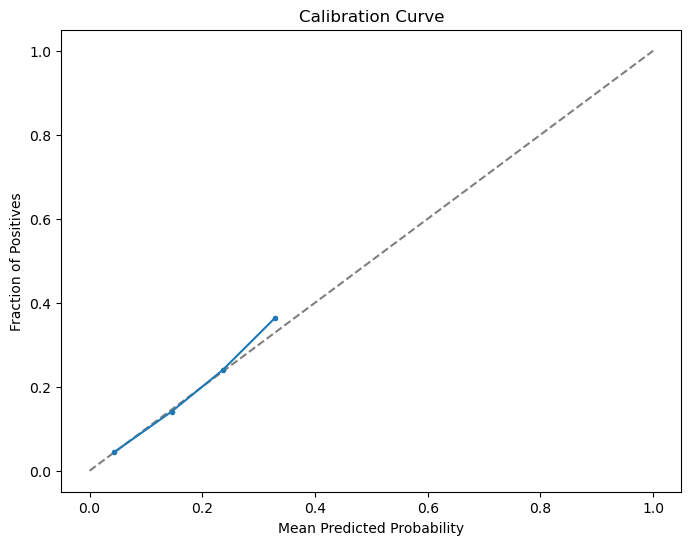

In [75]:
# Calibration Curve
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test_pca, y_prob_pca, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.plot(prob_pred, prob_true, marker=".")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.show()


### GPT:
Interpretation of the Calibration Curve:
Perfect Calibration Line (dashed gray line):

The diagonal line represents perfectly calibrated probabilities—this is where, for any given predicted probability, the fraction of actual positives exactly matches the predicted probability. For example, if the model predicts a probability of 0.2, we expect 20% of those predictions to actually default.
Your Model's Calibration (blue line):

Your model's predicted probabilities (blue line) generally stay close to the perfect calibration line up to about 0.3 predicted probability. However, beyond this point (i.e., for higher predicted probabilities), the model overestimates the default probability.
Key Points from the Curve:
Low Probability Predictions (0.0 to ~0.3):

In this range, the calibration is good. The predicted probabilities are closely aligned with the actual fraction of defaults, which means the model is correctly estimating the risk of default for most borrowers.
Higher Probability Predictions (>0.3):

Here, the model is slightly overestimating the likelihood of default. For instance, predicted probabilities in the range of 0.4 to 0.5 are resulting in actual default rates closer to 0.3. This means the model is too confident about high-risk borrowers, predicting a higher chance of default than what actually occurs.
Practical Impact on Business Decisions:
For Low to Moderate Probability Borrowers (e.g., PD < 0.3):

The model is well-calibrated, and you can trust these probabilities to set interest rates. For instance, a borrower with a predicted probability of 0.1 can be expected to have about a 10% chance of default, and interest rates should reflect this moderate risk accurately.
For High Probability Borrowers (e.g., PD > 0.3):

The model overestimates the default risk for these borrowers, meaning if you directly translate these predicted probabilities into interest rates, you might overcharge these high-risk borrowers relative to their actual risk.
You should consider adjusting the interest rates for these higher-risk groups to avoid unnecessarily high pricing, as the actual likelihood of default is lower than what the model predicts.
Next Steps to Address Overestimation:
Additional Calibration: If the overestimation for higher probabilities is a concern, you could consider applying further or alternative calibration techniques (e.g., more flexible isotonic regression) to refine this part of the probability spectrum.

Custom Thresholds: Adjust your decision thresholds based on the business context. For example, even though the model overestimates higher probabilities, you can still use custom thresholds (like 0.16) for classification, but adjust your interest rate scaling formula to prevent overpricing high-risk borrowers.

Business Decision-Making: Since the majority of your borrowers are in the low-risk range (based on earlier plots), this overestimation for high-risk borrowers may not impact a large portion of your loan portfolio. However, it's still worth refining to ensure that all customers are charged fairly based on their actual risk.

In [76]:
# Check model performance on entire dataset with best threshold

y_pred_best_threshold = calibrated_pipeline.predict_proba(X)[:, 1] > best_threshold

print(
    "MLP Classifier with PCA, Hyperparameter Tuning, and Probability Calibration on Entire Dataset"
)
print("Accuracy: ", accuracy_score(y, y_pred_best_threshold))
print("Balanced Accuracy: ", balanced_accuracy_score(y, y_pred_best_threshold))
print(classification_report(y, y_pred_best_threshold))
print("ROC AUC: ", roc_auc_score(y, y_pred_best_threshold))


MLP Classifier with PCA, Hyperparameter Tuning, and Probability Calibration on Entire Dataset
Accuracy:  0.7945
Balanced Accuracy:  0.638139552485044
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     90053
           1       0.23      0.44      0.30      9947

    accuracy                           0.79    100000
   macro avg       0.58      0.64      0.59    100000
weighted avg       0.86      0.79      0.82    100000

ROC AUC:  0.638139552485044


In [77]:
# Export the model
import joblib

joblib.dump(calibrated_pipeline, "calibrated_mlp_model_pipeline.pkl")

['calibrated_mlp_model_pipeline.pkl']

### Profitability Simulation

In [83]:
df_pred = X.copy()

df_pred["default"] = y

df_pred["estimated_probability_of_default"] = calibrated_pipeline.predict_proba(X)[:, 1]

In [85]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   married                           100000 non-null  int64  
 1   income                            100000 non-null  float64
 2   digital3                          100000 non-null  float64
 3   log_income                        100000 non-null  float64
 4   employment_retired                100000 non-null  bool   
 5   employment_student                100000 non-null  bool   
 6   employment_unemployed             100000 non-null  bool   
 7   sex_M                             100000 non-null  bool   
 8   PCA1                              100000 non-null  float64
 9   PCA2                              100000 non-null  float64
 10  default                           100000 non-null  int64  
 11  estimated_probability_of_default  100000 non-null  fl

In [86]:
def calculate_breakeven_rate(pd):
    return pd / (1 - pd)


In [87]:
# Define the risk premium for each risk category (initial assumptions)
risk_premiums = {
    "low": 0.02,  # 2% risk premium for low risk borrowers
    "moderate": 0.05,  # 5% risk premium for moderate risk borrowers
    "high": 0.10,  # 10% risk premium for high risk borrowers
}


In [88]:
# Define the initial risk categories (we will adjust these based on simulation)
def categorize_risk(pd):
    if pd < 0.10:
        return "low"
    elif 0.10 <= pd <= 0.25:
        return "moderate"
    else:
        return "high"


In [90]:
# Apply risk categorization
df_pred["risk_category"] = df_pred["estimated_probability_of_default"].apply(
    categorize_risk
)

# Calculate the break-even rate for each loan
df_pred["breakeven_rate"] = df_pred["estimated_probability_of_default"].apply(
    calculate_breakeven_rate
)

# Add the risk premium to the break-even rate based on the risk category
df_pred["final_rate"] = df_pred.apply(
    lambda x: x["breakeven_rate"] + risk_premiums[x["risk_category"]], axis=1
)


In [91]:
# Simulate the profitability for each loan
loan_amount = 10000  # Amount loaned per borrower
df_pred["profit"] = np.where(
    df_pred["default"] == 0,  # If no default
    df_pred["final_rate"] * loan_amount,  # Profit = interest earned
    -loan_amount,  # If default, the loss is the full loan amount
)


In [92]:
# Analyze the profitability by risk category
profit_by_category = df_pred.groupby("risk_category")["profit"].sum()
print(profit_by_category)


risk_category
high        1.716127e+06
low         1.063331e+07
moderate    1.759860e+07
Name: profit, dtype: float64


In [93]:
# Analyze how the distribution of risk categories looks
category_distribution = df_pred["risk_category"].value_counts()
print(category_distribution)


risk_category
low         57629
moderate    37747
high         4624
Name: count, dtype: int64


In [96]:
# Determine the threshold beyond which loans are too risky
# We can find the PD value where the expected profit turns negative
def find_loss_threshold(df):
    # Iterate through a range of probability thresholds from 0.0 to 1.0
    for pd_threshold in np.linspace(0.0, 1.0, 100):
        df["offer_loan"] = df["estimated_probability_of_default"] < pd_threshold

        # Calculate total profit for loans offered below this threshold
        total_profit = df[df["offer_loan"]]["profit"].sum()

        # Print the current threshold and profit for debugging
        print(f"Threshold: {pd_threshold}, Total Profit: {total_profit}")

        # If profit turns negative, we should stop and return this threshold
        if total_profit < 0:
            return pd_threshold, total_profit

    # If no threshold results in negative profit, return a default safe value
    print(
        "No threshold results in negative profit. Consider using a higher risk premium."
    )
    return 1.0, df[
        "profit"
    ].sum()  # No threshold found, so we return max PD and total profit


In [97]:
threshold, total_profit_at_threshold = find_loss_threshold(df_pred)
print(f"Threshold beyond which loans should not be given: {threshold}")
print(f"Total profit at that threshold: {total_profit_at_threshold}")


Threshold: 0.0, Total Profit: 0.0
Threshold: 0.010101010101010102, Total Profit: 0.0
Threshold: 0.020202020202020204, Total Profit: 3777984.358353409
Threshold: 0.030303030303030304, Total Profit: 5494106.829502627
Threshold: 0.04040404040404041, Total Profit: 6797497.174972983
Threshold: 0.05050505050505051, Total Profit: 7617329.2971418295
Threshold: 0.06060606060606061, Total Profit: 8366204.155588214
Threshold: 0.07070707070707072, Total Profit: 8758983.19800234
Threshold: 0.08080808080808081, Total Profit: 9732095.536298674
Threshold: 0.09090909090909091, Total Profit: 10120338.24280356
Threshold: 0.10101010101010102, Total Profit: 10750495.923743697
Threshold: 0.11111111111111112, Total Profit: 12385814.897297887
Threshold: 0.12121212121212122, Total Profit: 13911760.518778704
Threshold: 0.13131313131313133, Total Profit: 15516903.641530372
Threshold: 0.14141414141414144, Total Profit: 16588630.4679234
Threshold: 0.15151515151515152, Total Profit: 18066277.589976475
Threshold: 0.